# McCall Job Search Model: Complete Rebuild

**Author**: Haoyuan Li

---

## 1. Introduction

### What is the McCall job search model?

The McCall job search model is a foundational framework in labor economics for thinking about unemployment, job offers, and optimal search behavior. An unemployed worker receives random wage offers over time and must decide whether to accept the current offer or remain unemployed and keep searching.

At each date the worker faces a fundamental trade-off:

- **Accept now**: lock in the current wage and forgo the possibility of better future offers.
- **Wait and search**: collect unemployment benefits today and preserve the option to take higher wages in the future, at the cost of delay.

These decisions are forward-looking and naturally expressed as a dynamic programming problem.

### Why job-search models matter

Job-search models are useful because they

- provide a micro-founded explanation for unemployment as an outcome of optimal choice,
- clarify how policies such as unemployment benefits affect search intensity, acceptance behavior, and unemployment duration,
- connect equilibrium wages and unemployment to underlying frictions and uncertainty,
- offer a clean entry point into dynamic programming, value function iteration, and numerical methods in economics.

### Overview of this notebook (Sections I–VIII)

This notebook reconstructs and integrates several variants of the McCall model into a single, coherent exposition. All text is written from scratch, but the economic content and numerical methods follow the original QuantEcon lectures.

- **I. Introduction**
  - Economic motivation and structure of the notebook.
- **II. Baseline McCall Model**
  - Discrete wage offers, no separation, reservation wage, and value function iteration.
- **III. McCall Model with Separation**
  - Jobs can be destroyed, two value functions (employed and unemployed), and reservation wage analysis.
- **IV. Separation with Markov Wages**
  - Wages follow a Markov process rather than being IID; dynamic programming with a transition matrix.
- **V. Fitted Value Function Iteration**
  - Continuous-state wage dynamics and interpolation-based value function iteration.
- **VI. Persistent and Transitory Wage Shocks**
  - Wage decomposition into persistent and transitory components, and a reduced-form dynamic programming problem.
- **VII. Single-Agent Simulation**
  - Simulated offer sequences, acceptance behavior, and employment/unemployment paths under an optimal policy.
- **VIII. Summary and Insights**
  - Main economic lessons and computational takeaways from the different model variants.

Throughout, we use clear LaTeX notation, JAX-based numerical code, and consistent matplotlib plots so that the notebook can be run top-to-bottom and used as a GitHub-ready teaching or research resource.


In [1]:
import math
from typing import NamedTuple

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from quantecon.distributions import BetaBinomial
from quantecon.markov import tauchen

# Plot style
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["font.size"] = 12


def crra_utility(x: jnp.ndarray, gamma: float) -> jnp.ndarray:
    """CRRA utility function u(x) = (x^{1-gamma} - 1) / (1-gamma).

    For gamma = 1 this would become log utility; here we focus on gamma != 1.
    """
    return (x ** (1.0 - gamma) - 1.0) / (1.0 - gamma)


def ensure_positive(x: jnp.ndarray, eps: float = 1e-8) -> jnp.ndarray:
    """Helper to guard against negative values in log or power operations."""
    return jnp.maximum(x, eps)


## 2. Baseline McCall Model

In this section we work with the classic version of the McCall job search model.
An infinitely lived worker discounts the future at factor $0 < \beta < 1$ and receives, in each period, a wage offer $W$ drawn independently from a known distribution over a finite grid $\mathcal{W}$.

If the worker is unemployed and observes offer $w$, they can either

- **accept the job** and work forever at wage $w$, or
- **reject the offer**, receive unemployment benefit $c$, and wait for a new draw next period.

The worker chooses a strategy to maximize the expected discounted sum of income
$$
\mathbb{E} \left[ \sum_{t=0}^{\infty} \beta^t y_t \right],
$$
where $y_t$ is the income in period $t$.

### 2.1 Bellman equation and reservation wage

Let $V(w)$ denote the value of being unemployed, having current offer $w$ in hand and behaving optimally from now on.
If the worker accepts, the present value of the wage stream is
$$
V^{\text{acc}}(w) = \frac{w}{1 - \beta}.
$$
If they reject, they receive $c$ today and then face the same decision problem next period, so the continuation value is
$$
V^{\text{rej}} = c + \beta \sum_{w' \in \mathcal{W}} V(w') q(w'),
$$
where $q(w')$ is the probability mass function of the wage distribution.

The Bellman equation is therefore
$$
V(w) = \max \left\{ \frac{w}{1 - \beta},\; c + \beta \sum_{w' \in \mathcal{W}} V(w') q(w') \right\}.
$$

The optimal policy has a **reservation wage** $\bar{w}$: there exists a cutoff such that the worker accepts an offer if and only if $w \geq \bar{w}$.
From the Bellman equation, at the cutoff the worker must be indifferent between accepting and rejecting, which yields
$$
\frac{\bar{w}}{1 - \beta} = c + \beta \sum_{w' \in \mathcal{W}} V(w') q(w').
$$
Solving for the reservation wage gives
$$
\bar{w} = (1 - \beta) \left( c + \beta \sum_{w' \in \mathcal{W}} V(w') q(w') \right).
$$
In practice, we approximate $V$ by value function iteration and then compute $\bar{w}$ from the expression above.


In [ ]:
class BaselineMcCallParams(NamedTuple):
    """Parameter container and helpers for the baseline McCall model."""

    beta: float = 0.99          # discount factor
    c: float = 25.0             # unemployment compensation
    w_min: float = 10.0         # minimum wage in the grid
    w_max: float = 60.0         # maximum wage in the grid
    n_wages: int = 51           # number of wage grid points

    @property
    def w_grid(self) -> jnp.ndarray:
        """Equally spaced wage grid on [w_min, w_max]."""
        return jnp.linspace(self.w_min, self.w_max, self.n_wages)

    @property
    def q_probs(self) -> jnp.ndarray:
        """Discrete wage offer distribution on the grid.

        We use a Beta-binomial distribution as a flexible discrete
        approximation to a unimodal wage offer density.
        """
        n = self.n_wages - 1
        dist = BetaBinomial(n, 200, 100)
        return jnp.array(dist.pdf())


def bellman_operator_baseline(params: BaselineMcCallParams,
                              V: jnp.ndarray) -> jnp.ndarray:
    """Bellman operator for the baseline McCall model.

    Given a current guess V of the value function on the wage grid,
    returns T V according to the Bellman equation.
    """
    beta = params.beta
    c = params.c
    w = params.w_grid
    q = params.q_probs

    # Value of accepting the current offer: work forever at wage w
    accept_value = w / (1.0 - beta)

    # Value of rejecting: unemployment compensation plus discounted
    # expected value of facing a fresh wage draw next period
    continuation_value = c + beta * (V @ q)

    # Pointwise maximum implements the Bellman operator
    return jnp.maximum(accept_value, continuation_value)


def solve_baseline_mccall(params: BaselineMcCallParams,
                          tol: float = 1e-6,
                          max_iter: int = 500) -> tuple[jnp.ndarray, float, int]:
    """Value function iteration for the baseline model.

    Returns (V_star, w_bar, n_iter), where
    - V_star is the approximate fixed point of the Bellman operator,
    - w_bar is the implied reservation wage, and
    - n_iter is the number of iterations used.
    """
    beta = params.beta
    w = params.w_grid
    q = params.q_probs

    # Start from the value of always accepting: V_0(w) = w / (1 - beta)
    V = w / (1.0 - beta)
    error = jnp.inf
    it = 0

    # Simple fixed-point iteration on the Bellman operator
    while (error > tol) and (it < max_iter):
        V_new = bellman_operator_baseline(params, V)
        error = jnp.max(jnp.abs(V_new - V))
        V = V_new
        it += 1

    # Once V has converged, compute the continuation value and the
    # implied reservation wage using the indifference condition
    continuation_value = params.c + beta * (V @ q)
    w_bar = (1.0 - beta) * continuation_value
    return V, w_bar, it


# Solve and report the baseline McCall model
baseline_params = BaselineMcCallParams()
V_star_baseline, w_bar_baseline, it_baseline = solve_baseline_mccall(baseline_params)

print(f"Baseline McCall: reservation wage = {float(w_bar_baseline):.3f}")
print(f"Number of value function iterations: {it_baseline}")


Baseline McCall: reservation wage = 47.316
Number of value function iterations: 78


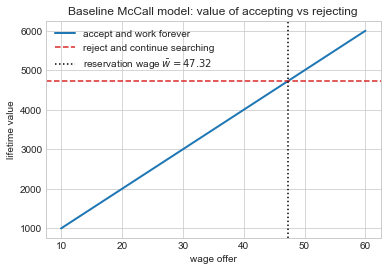

In [3]:
def plot_baseline_value_and_policy(params: BaselineMcCallParams,
                                   V_star: jnp.ndarray,
                                   w_bar: float) -> None:
    w = np.asarray(params.w_grid)
    beta = params.beta

    accept_value = w / (1.0 - beta)
    continuation_value = params.c + beta * float(V_star @ params.q_probs)

    fig, ax = plt.subplots()
    ax.plot(w, accept_value, label="accept and work forever", lw=2)
    ax.axhline(continuation_value, color="tab:red", linestyle="--",
               label="reject and continue searching")
    ax.axvline(w_bar, color="k", linestyle=":",
               label=fr"reservation wage $\bar{{w}} = {w_bar:.2f}$")

    ax.set_xlabel("wage offer")
    ax.set_ylabel("lifetime value")
    ax.set_title("Baseline McCall model: value of accepting vs rejecting")
    ax.legend()
    plt.show()


plot_baseline_value_and_policy(baseline_params, V_star_baseline, float(w_bar_baseline))


## 3. McCall Model with Separation

In the baseline model, once a job is accepted it lasts forever. This is unrealistic: in real labor markets, jobs end for many reasons, including layoffs and firm closures.
We now extend the McCall model by introducing an exogenous separation probability.

### 3.1 Economic environment and timing

- Time is discrete and the worker is infinitely lived.
- In each period the worker can be either **employed** at wage $w$ or **unemployed**.
- Wage offers for unemployed workers are drawn IID from a finite grid $\mathcal{W}$ with probabilities $q(w)$.
- When employed at wage $w$, the worker receives utility $u(w)$ and keeps the job into the next period with probability $1 - \alpha$.
- With probability $\alpha$, the job is destroyed at the end of the period, and the worker becomes unemployed next period.
- Unemployed workers receive unemployment compensation $c$ each period.
- Future utilities are discounted by factor $\beta \in (0, 1)$.

We adopt a CRRA utility function
$$
u(x) = \frac{x^{1 - \gamma} - 1}{1 - \gamma}, \quad \gamma > 0, \gamma \neq 1.
$$

### 3.2 Bellman equations and continuation value

Let

- $V_e(w)$ be the value of being employed today at wage $w$.
- $V_u(w)$ be the value of being unemployed today, having current offer $w$ in hand.

The Bellman equations are
$$
V_u(w) = \max \left\{ V_e(w),\; u(c) + \beta \sum_{w' \in \mathcal{W}} V_u(w') q(w') \right\},
$$
and
$$
V_e(w) = u(w) + \beta \left[ (1 - \alpha) V_e(w) + \alpha \sum_{w' \in \mathcal{W}} V_u(w') q(w') \right].
$$

Define the **continuation value** for an unemployed worker as
$$
H = u(c) + \beta \sum_{w' \in \mathcal{W}} V_u(w') q(w').
$$

An unemployed worker accepts an offer $w$ if $V_e(w) \geq H$. Because $V_e(w)$ is increasing in $w$, the optimal policy is again a reservation wage strategy: there exists $\bar{w}$ such that
$$
\text{accept} \iff w \geq \bar{w}.
$$
The reservation wage is the smallest wage on the grid satisfying $V_e(w) \geq H$.

We now implement value function iteration and compute $\bar{w}$ numerically.


In [ ]:
class SeparationParams(NamedTuple):
    """Parameters for the McCall model with exogenous job separation."""

    alpha: float                # separation probability each period
    beta: float                 # discount factor
    gamma: float                # CRRA risk aversion parameter
    c: float                    # unemployment compensation
    w_grid: jnp.ndarray         # wage offer grid
    q_probs: jnp.ndarray        # discrete wage offer distribution


def create_default_separation_params() -> SeparationParams:
    """Construct a default calibration for the separation model."""
    n = 60
    w_grid = jnp.linspace(10.0, 20.0, n)
    a, b = 600, 400
    dist = BetaBinomial(n - 1, a, b)
    q_probs = jnp.array(dist.pdf())
    return SeparationParams(alpha=0.2, beta=0.98, gamma=2.0, c=6.0,
                            w_grid=w_grid, q_probs=q_probs)


def T_u_separation(params: SeparationParams,
                   V_u: jnp.ndarray,
                   V_e: jnp.ndarray) -> jnp.ndarray:
    """Bellman update for the unemployed worker's value function.

    Given current guesses (V_u, V_e), compute the updated unemployed
    value using the Bellman equation for V_u.
    """
    alpha, beta, gamma, c, w, q = (
        params.alpha,
        params.beta,
        params.gamma,
        params.c,
        params.w_grid,
        params.q_probs,
    )
    # Continuation value from remaining unemployed today
    H = crra_utility(jnp.array(c), gamma) + beta * (V_u @ q)
    # Compare value of accepting (V_e) to the continuation value
    return jnp.maximum(V_e, H)


def T_e_separation(params: SeparationParams,
                   V_u: jnp.ndarray,
                   V_e: jnp.ndarray) -> jnp.ndarray:
    """Bellman update for the employed worker's value function.

    Given current guesses (V_u, V_e), compute the updated employed value
    using the Bellman equation for V_e.
    """
    alpha, beta, gamma, c, w, q = (
        params.alpha,
        params.beta,
        params.gamma,
        params.c,
        params.w_grid,
        params.q_probs,
    )
    # Flow utility u(w) plus discounted continuation value, where with
    # probability (1 - alpha) the job survives and with probability
    # alpha the worker becomes unemployed and receives V_u in expectation
    return (crra_utility(w, gamma)
            + beta * ((1.0 - alpha) * V_e + alpha * (V_u @ q)))


def solve_separation_full(params: SeparationParams,
                          tol: float = 1e-6,
                          max_iter: int = 1_000) -> tuple[jnp.ndarray, jnp.ndarray]:
    """Iterate jointly on (V_u, V_e) until convergence.

    Returns the pair (V_u_star, V_e_star).
    """
    beta = params.beta
    w = params.w_grid

    # Initialize both value functions at the value of a permanent job
    V_u = w / (1.0 - beta)
    V_e = V_u.copy()
    error = jnp.inf
    it = 0

    while (error > tol) and (it < max_iter):
        # Apply the two Bellman updates
        V_u_new = T_u_separation(params, V_u, V_e)
        V_e_new = T_e_separation(params, V_u, V_e)
        # Track the worst-case change
        error_u = jnp.max(jnp.abs(V_u_new - V_u))
        error_e = jnp.max(jnp.abs(V_e_new - V_e))
        error = jnp.maximum(error_u, error_e)
        V_u, V_e = V_u_new, V_e_new
        it += 1

    return V_u, V_e


def compute_reservation_wage_separation(params: SeparationParams,
                                         V_u: jnp.ndarray,
                                         V_e: jnp.ndarray) -> float:
    """Compute the reservation wage implied by (V_u, V_e).

    The reservation wage is the smallest wage such that accepting is at
    least as good as continuing to search.
    """
    alpha, beta, gamma, c, w, q = (
        params.alpha,
        params.beta,
        params.gamma,
        params.c,
        params.w_grid,
        params.q_probs,
    )
    H = crra_utility(jnp.array(c), gamma) + beta * (V_u @ q)
    accepts = V_e >= H
    idx = int(jnp.argmax(accepts))
    if not bool(jnp.any(accepts)):
        return math.inf
    return float(w[idx])


# Solve the separation model and report the reservation wage
sep_params = create_default_separation_params()
V_u_sep, V_e_sep = solve_separation_full(sep_params)
w_bar_sep = compute_reservation_wage_separation(sep_params, V_u_sep, V_e_sep)

print(f"Separation model: reservation wage = {w_bar_sep:.3f}")


Separation model: reservation wage = 11.864


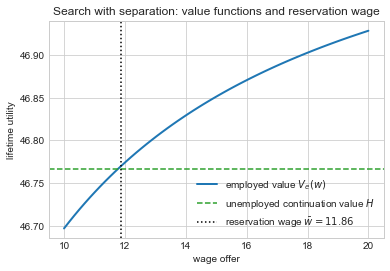

In [5]:
def plot_separation_values(params: SeparationParams,
                           V_u: jnp.ndarray,
                           V_e: jnp.ndarray,
                           w_bar: float) -> None:
    alpha, beta, gamma, c, w, q = (
        params.alpha,
        params.beta,
        params.gamma,
        params.c,
        np.asarray(params.w_grid),
        params.q_probs,
    )
    H = float(crra_utility(jnp.array(c), gamma) + beta * (V_u @ q))

    fig, ax = plt.subplots()
    ax.plot(w, V_e, label="employed value $V_e(w)$", lw=2)
    ax.axhline(H, color="tab:green", linestyle="--",
               label="unemployed continuation value $H$")
    ax.axvline(w_bar, color="k", linestyle=":",
               label=fr"reservation wage $\bar{{w}} = {w_bar:.2f}$")

    ax.set_xlabel("wage offer")
    ax.set_ylabel("lifetime utility")
    ax.set_title("Search with separation: value functions and reservation wage")
    ax.legend()
    plt.show()


plot_separation_values(sep_params, V_u_sep, V_e_sep, w_bar_sep)


## 4. Separation with Markov Wages

The previous section assumed that wage offers are IID over time. In many applications, however, labor market conditions are persistent: good times and bad times tend to come in clusters.
To introduce persistence in offers, we assume that wages follow a Markov process.

### 4.1 Markov wage process

Let $\{X_t\}$ follow an autoregressive process
$$
X_{t+1} = \rho X_t + \nu Z_{t+1},
$$
where $\{Z_t\}$ is IID standard normal and $0 < \rho < 1$.
We interpret the wage as
$$
W_t = \exp(X_t),
$$
so that wages are always positive and approximately log-normal.

We discretize this process using Tauchen's method to obtain a grid of wage values $\{w_1, \dots, w_n\}$ and an $n \times n$ Markov transition matrix $P$ such that
$$
P_{ij} \approx \Pr(W_{t+1} = w_j \mid W_t = w_i).
$$

### 4.2 Bellman equations with separation and Markov wages

The worker again faces separation risk with probability $\alpha$ and receives benefit $c$ when unemployed. With CRRA utility $u(\cdot)$ and discount factor $\beta$, the Bellman equations become
$$
V_u(w_i) = \max \left\{ V_e(w_i),\; u(c) + \beta \sum_{j=1}^n V_u(w_j) P_{ij} \right\},
$$
$$
V_e(w_i) = u(w_i) + \beta \left[ (1 - \alpha) V_e(w_i) + \alpha \sum_{j=1}^n V_u(w_j) P_{ij} \right].
$$

It is convenient to eliminate $V_e$ from the iteration and work with a single operator on the unemployed value function.
Using the employed Bellman equation we can write
$$
V_e(w_i) = \frac{u(w_i) + \alpha \beta (P V_u)(w_i)}{1 - \beta(1 - \alpha)},
$$
where $(P V_u)(w_i) = \sum_{j=1}^n V_u(w_j) P_{ij}$.
Substituting into the unemployed Bellman equation gives a Bellman operator $T$ on $V_u$ alone,
$$
(T V_u)(w_i) = \max \left\{ \frac{u(w_i) + \alpha \beta (P V_u)(w_i)}{1 - \beta(1 - \alpha)},\; u(c) + \beta (P V_u)(w_i) \right\}.
$$

We now implement value function iteration on this operator and compute the implied reservation wage.


In [ ]:
class MarkovSeparationParams(NamedTuple):
    """Parameters for the separation model with Markovian wages."""

    alpha: float
    beta: float
    gamma: float
    c: float
    rho: float
    nu: float
    n_states: int
    w_vals: jnp.ndarray
    P: jnp.ndarray
    P_cumsum: jnp.ndarray


def create_default_markov_params() -> MarkovSeparationParams:
    """Create a Tauchen-discretized AR(1) wage process with separation."""
    n_states = 200
    rho = 0.9
    nu = 0.2
    beta = 0.96
    alpha = 0.05
    c = 1.0
    gamma = 1.5

    # Discretize the AR(1) process for log wages
    mc = tauchen(n_states, rho, nu)
    w_vals = jnp.exp(jnp.array(mc.state_values))
    P = jnp.array(mc.P)
    # Row-wise cumulative sum is useful for fast simulation
    P_cumsum = jnp.cumsum(P, axis=1)
    return MarkovSeparationParams(alpha=alpha, beta=beta, gamma=gamma, c=c,
                                  rho=rho, nu=nu, n_states=n_states,
                                  w_vals=w_vals, P=P, P_cumsum=P_cumsum)


def bellman_operator_markov(V_u: jnp.ndarray,
                            params: MarkovSeparationParams) -> jnp.ndarray:
    """Bellman operator for the unemployed value function in the Markov model."""
    alpha, beta, gamma, c, rho, nu, n, w, P, P_cumsum = (
        params.alpha,
        params.beta,
        params.gamma,
        params.c,
        params.rho,
        params.nu,
        params.n_states,
        params.w_vals,
        params.P,
        params.P_cumsum,
    )
    # Compute expected unemployed value conditional on current wage state
    PV = P @ V_u
    # Closed-form expression for the employed value as a function of PV
    d = 1.0 / (1.0 - beta * (1.0 - alpha))
    V_e = d * (crra_utility(w, gamma) + alpha * beta * PV)
    # Continuation value if unemployed today
    H = crra_utility(jnp.array(c), gamma) + beta * PV
    # Take the better of accepting (V_e) and rejecting (H)
    return jnp.maximum(V_e, H)


def vfi_markov(params: MarkovSeparationParams,
               tol: float = 1e-6,
               max_iter: int = 50_000) -> jnp.ndarray:
    """Value function iteration for the Markov wage model.

    Iterates on the unemployed value function until convergence.
    """
    V_u = jnp.zeros_like(params.w_vals)
    error = jnp.inf
    it = 0

    while (error > tol) and (it < max_iter):
        V_new = bellman_operator_markov(V_u, params)
        error = jnp.max(jnp.abs(V_new - V_u))
        V_u = V_new
        it += 1

    print(f"Markov model: value function iterations = {it}")
    return V_u


def get_reservation_wage_markov(V_u: jnp.ndarray,
                                 params: MarkovSeparationParams) -> tuple[float, jnp.ndarray, jnp.ndarray]:
    """Compute the reservation wage and associated value functions.

    Returns (w_bar, V_e, H), where V_e is the employed value function and
    H is the unemployed continuation value as a function of the current
    wage state.
    """
    alpha, beta, gamma, c, rho, nu, n, w, P, P_cumsum = (
        params.alpha,
        params.beta,
        params.gamma,
        params.c,
        params.rho,
        params.nu,
        params.n_states,
        params.w_vals,
        params.P,
        params.P_cumsum,
    )
    PV = P @ V_u
    d = 1.0 / (1.0 - beta * (1.0 - alpha))
    V_e = d * (crra_utility(w, gamma) + alpha * beta * PV)
    H = crra_utility(jnp.array(c), gamma) + beta * PV

    accepts = V_e >= H
    idx = int(jnp.argmax(accepts))
    if not bool(jnp.any(accepts)):
        w_bar = math.inf
    else:
        w_bar = float(w[idx])
    return w_bar, V_e, H


# Solve the Markov wage separation model and report the reservation wage
markov_params = create_default_markov_params()
V_u_markov = vfi_markov(markov_params)
w_bar_markov, V_e_markov, H_markov = get_reservation_wage_markov(V_u_markov, markov_params)

print(f"Markov separation model: reservation wage = {w_bar_markov:.3f}")


Markov model: value function iterations = 178
Markov separation model: reservation wage = 1.365


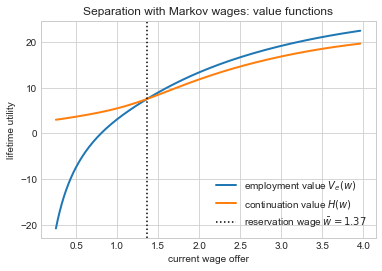

In [7]:
def plot_markov_values(params: MarkovSeparationParams,
                       V_e: jnp.ndarray,
                       H: jnp.ndarray,
                       w_bar: float) -> None:
    w = np.asarray(params.w_vals)

    fig, ax = plt.subplots()
    ax.plot(w, V_e, label="employment value $V_e(w)$", lw=2)
    ax.plot(w, H, label="continuation value $H(w)$", lw=2)
    if math.isfinite(w_bar):
        ax.axvline(w_bar, color="k", linestyle=":",
                   label=fr"reservation wage $\bar{{w}} = {w_bar:.2f}$")

    ax.set_xlabel("current wage offer")
    ax.set_ylabel("lifetime utility")
    ax.set_title("Separation with Markov wages: value functions")
    ax.legend()
    plt.show()


plot_markov_values(markov_params, V_e_markov, H_markov, w_bar_markov)


## 5. Fitted Value Function Iteration

The Markov model above uses a finite-state approximation for the wage process. In many applications it is natural to treat wages as truly continuous.
Direct value function iteration in a continuous state space is infeasible, but we can combine value function iteration with interpolation to obtain an efficient algorithm known as **fitted value function iteration**.

### 5.1 Continuous wage process and Bellman operator

Consider again a separation model with wages
$$
W_t = \exp(X_t), \qquad X_{t+1} = \rho X_t + \nu Z_{t+1},
$$
where $Z_{t+1}$ is standard normal. Given current wage $w$, the conditional distribution of next period's wage $W'$ is continuous.

Let $V_u(\cdot)$ denote the unemployed value function. The key object in the Bellman operator is the conditional expectation
$$
(P V_u)(w) = \mathbb{E} \left[ V_u(W') \mid W = w \right].
$$
For the separation model, the Bellman operator on $V_u$ can be written as
$$
(T V_u)(w) = \max \left\{ \frac{u(w) + \alpha \beta (P V_u)(w)}{1 - \beta(1 - \alpha)},\; u(c) + \beta (P V_u)(w) \right\}.
$$

### 5.2 Fitted value function iteration

We approximate $V_u$ on a wage grid $\{w_1, \dots, w_I\}$ by storing its values in a vector $v \in \mathbb{R}^I$ and using piecewise linear interpolation between grid points.
Given an approximation $v$ and grid $\{w_i\}$, the algorithm proceeds as:

1. Interpolate to obtain a function $\hat{V}_u$ defined on the entire state space.
2. For each grid point $w_i$, approximate $(P V_u)(w_i)$ by Monte Carlo integration using draws from the wage transition.
3. Apply the Bellman operator to obtain updated values $v'_i = (T V_u)(w_i)$.
4. Repeat until $v$ and $v'$ are sufficiently close.

We now implement this algorithm in JAX.


In [ ]:
class FittedVFParams(NamedTuple):
    """Parameters for the fitted value function iteration model."""

    c: float
    alpha: float
    beta: float
    rho: float
    nu: float
    gamma: float
    w_grid: jnp.ndarray
    z_draws: jnp.ndarray


def create_fitted_vf_params(c: float = 1.0,
                            alpha: float = 0.05,
                            beta: float = 0.96,
                            rho: float = 0.9,
                            nu: float = 0.2,
                            gamma: float = 1.5,
                            grid_size: int = 100,
                            mc_size: int = 1_000,
                            seed: int = 1234) -> FittedVFParams:
    """Factory for a separation model with a continuous wage process.

    The AR(1) process for log wages is discretized only to construct an
    interpolation grid; the expectation is computed via Monte Carlo.
    """
    key = jax.random.PRNGKey(seed)
    z_draws = jax.random.normal(key, (mc_size,))

    mc = qe.markov.tauchen(grid_size, rho, nu)
    w_grid = jnp.exp(jnp.array(mc.state_values))

    return FittedVFParams(c=c, alpha=alpha, beta=beta, rho=rho, nu=nu,
                          gamma=gamma, w_grid=w_grid, z_draws=z_draws)


def bellman_operator_fitted(params: FittedVFParams,
                            V_u: jnp.ndarray) -> jnp.ndarray:
    """Bellman operator for the continuous wage separation model."""
    c, alpha, beta, rho, nu, gamma, w_grid, z_draws = (
        params.c,
        params.alpha,
        params.beta,
        params.rho,
        params.nu,
        params.gamma,
        params.w_grid,
        params.z_draws,
    )

    # Interpolated value function \hat{V}_u used off the grid
    def vf(x: jnp.ndarray) -> jnp.ndarray:
        return jnp.interp(x, w_grid, V_u)

    # Monte Carlo approximation of the conditional expectation E[V_u(W') | W = w]
    def compute_expectation(w: jnp.ndarray) -> jnp.ndarray:
        w_next = w ** rho * jnp.exp(nu * z_draws)
        return jnp.mean(vf(w_next))

    compute_exp_on_grid = jax.vmap(compute_expectation)
    PV = compute_exp_on_grid(w_grid)

    d = 1.0 / (1.0 - beta * (1.0 - alpha))
    V_e = d * (crra_utility(w_grid, gamma) + alpha * beta * PV)
    H = crra_utility(jnp.array(c), gamma) + beta * PV
    return jnp.maximum(V_e, H)


def vfi_fitted(params: FittedVFParams,
               tol: float = 1e-5,
               max_iter: int = 50_000) -> jnp.ndarray:
    """Fitted value function iteration on the continuous wage space."""
    V_u = jnp.zeros_like(params.w_grid)
    error = jnp.inf
    it = 0

    while (error > tol) and (it < max_iter):
        V_new = bellman_operator_fitted(params, V_u)
        error = jnp.max(jnp.abs(V_new - V_u))
        V_u = V_new
        it += 1

    print(f"Fitted VFI: value function iterations = {it}")
    return V_u


def compute_solution_functions_fitted(params: FittedVFParams,
                                      V_u: jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray]:
    """Recover V_e and the unemployed continuation value H from V_u."""
    c, alpha, beta, rho, nu, gamma, w_grid, z_draws = (
        params.c,
        params.alpha,
        params.beta,
        params.rho,
        params.nu,
        params.gamma,
        params.w_grid,
        params.z_draws,
    )

    def vf(x: jnp.ndarray) -> jnp.ndarray:
        return jnp.interp(x, w_grid, V_u)

    def compute_expectation(w: jnp.ndarray) -> jnp.ndarray:
        w_next = w ** rho * jnp.exp(nu * z_draws)
        return jnp.mean(vf(w_next))

    compute_exp_on_grid = jax.vmap(compute_expectation)
    PV = compute_exp_on_grid(w_grid)

    d = 1.0 / (1.0 - beta * (1.0 - alpha))
    V_e = d * (crra_utility(w_grid, gamma) + alpha * beta * PV)
    H = crra_utility(jnp.array(c), gamma) + beta * PV
    return V_e, H


def get_reservation_wage_fitted(params: FittedVFParams,
                                 V_e: jnp.ndarray,
                                 H: jnp.ndarray) -> float:
    """Compute the reservation wage from V_e and H on the grid."""
    w = params.w_grid
    accepts = V_e >= H
    idx = int(jnp.argmax(accepts))
    if not bool(jnp.any(accepts)):
        return math.inf
    return float(w[idx])


# Solve the fitted VFI model and report the reservation wage
fitted_params = create_fitted_vf_params()
V_u_fitted = vfi_fitted(fitted_params)
V_e_fitted, H_fitted = compute_solution_functions_fitted(fitted_params, V_u_fitted)
w_bar_fitted = get_reservation_wage_fitted(fitted_params, V_e_fitted, H_fitted)

print(f"Fitted VFI model: reservation wage = {w_bar_fitted:.3f}")


Fitted VFI: value function iterations = 144
Fitted VFI model: reservation wage = 1.377


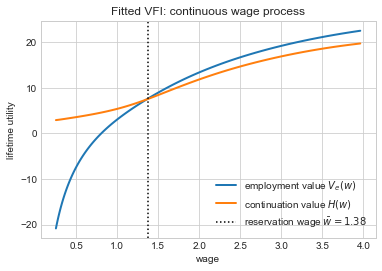

In [9]:
def plot_fitted_vfi(params: FittedVFParams,
                    V_e: jnp.ndarray,
                    H: jnp.ndarray,
                    w_bar: float) -> None:
    w = np.asarray(params.w_grid)

    fig, ax = plt.subplots()
    ax.plot(w, V_e, label="employment value $V_e(w)$", lw=2)
    ax.plot(w, H, label="continuation value $H(w)$", lw=2)
    if math.isfinite(w_bar):
        ax.axvline(w_bar, color="k", linestyle=":",
                   label=fr"reservation wage $\bar{{w}} = {w_bar:.2f}$")

    ax.set_xlabel("wage")
    ax.set_ylabel("lifetime utility")
    ax.set_title("Fitted VFI: continuous wage process")
    ax.legend()
    plt.show()


plot_fitted_vfi(fitted_params, V_e_fitted, H_fitted, w_bar_fitted)


## 6. Persistent and Transitory Wage Shocks

So far, the wage process has been summarized by a single state variable. Many empirical studies of earnings dynamics instead model wages as a sum of a **persistent** component and a **transitory** component.

### 6.1 Wage decomposition

We follow a specification of the form
$$
W_t = \exp(Z_t) + Y_t,
$$
where
$$
Y_t = \exp(\mu + s \zeta_t), \qquad Z_{t+1} = d + \rho Z_t + \sigma \epsilon_{t+1}.
$$
Here $\{\zeta_t\}$ and $\{\epsilon_t\}$ are IID standard normal.
The process $\{Z_t\}$ captures **persistent** shocks, while $\{Y_t\}$ represents **transitory** fluctuations.

Jobs are permanent once accepted, as in the baseline McCall model. An unemployed worker either

1. accepts an offer and then works forever at wage $W_t$, or
2. rejects and receives benefit $c$, drawing a new pair $(Z_{t+1}, Y_{t+1})$ next period.

We assume log utility $u(x) = \log(x)$ for this section.

### 6.2 Reduced-form dynamic programming problem

Let $v^*(w, z)$ be the value of being unemployed when the current state is $(w, z)$, where $z$ summarizes the persistent component.
Define the **continuation value** function
$$
f^*(z) = u(c) + \beta \, \mathbb{E}_z \left[ v^*(W', Z') \right],
$$
where the expectation is taken over next period's shocks conditional on the current value of $Z$.
At any state $(w, z)$ the worker compares the value of accepting,
$$
\frac{u(w)}{1 - \beta},
$$
with the continuation value $f^*(z)$. It is optimal to accept if
$$
\frac{u(w)}{1 - \beta} \geq f^*(z).
$$

Using this condition, one can show that $f^*$ is the unique fixed point of the operator
$$
(Q f)(z) = u(c) + \beta \, \mathbb{E}_z \left[ \max \left\{ \frac{u(W')}{1 - \beta}, f(Z') \right\} \right].
$$
Once $f^*$ is known, the reservation wage as a function of the persistent state $z$ is
$$
\bar{w}(z) = \exp\left( f^*(z) (1 - \beta) \right),
$$
reflecting the threshold at which accepting and rejecting yield the same lifetime utility.

We now compute $f^*$ numerically using fitted value function iteration on a grid for $z$ and Monte Carlo integration over shocks.


In [ ]:
class PersistTransParams(NamedTuple):
    """Parameters for the model with persistent and transitory wage shocks."""

    mu: float
    s: float
    d: float
    rho: float
    sigma: float
    beta: float
    c: float
    z_grid: jnp.ndarray
    e_draws: jnp.ndarray


def create_persist_trans_params(mu: float = 0.0,
                                s: float = 1.0,
                                d: float = 0.0,
                                rho: float = 0.9,
                                sigma: float = 0.1,
                                beta: float = 0.98,
                                c: float = 5.0,
                                mc_size: int = 1_000,
                                grid_size: int = 100,
                                seed: int = 1234) -> PersistTransParams:
    """Create a grid and shock draws for the persistent/transitory model."""
    key = jax.random.PRNGKey(seed)

    # Construct a grid for the persistent component Z around its mean
    z_mean = d / (1.0 - rho)
    z_sd = sigma / jnp.sqrt(1.0 - rho ** 2)
    k = 3.0
    a, b = z_mean - k * z_sd, z_mean + k * z_sd
    z_grid = jnp.linspace(a, b, grid_size)

    # Two-dimensional normal draws: one for the persistent shock, one
    # for the transitory shock each period
    e_draws = jax.random.normal(key, (2, mc_size))
    return PersistTransParams(mu=mu, s=s, d=d, rho=rho, sigma=sigma,
                              beta=beta, c=c, z_grid=z_grid, e_draws=e_draws)


def log_utility(x: jnp.ndarray) -> jnp.ndarray:
    """Log utility with a small safeguard for numerical stability."""
    return jnp.log(ensure_positive(x))


def Q_operator(params: PersistTransParams,
               f_in: jnp.ndarray) -> jnp.ndarray:
    """Apply the Q operator defining the fixed point f*.

    Given a function f represented on the z_grid, compute Q f according
    to the reduced-form dynamic programming problem.
    """
    mu, s, d, rho, sigma, beta, c, z_grid, e_draws = (
        params.mu,
        params.s,
        params.d,
        params.rho,
        params.sigma,
        params.beta,
        params.c,
        params.z_grid,
        params.e_draws,
    )
    M = e_draws.shape[1]

    def compute_expectation(z: jnp.ndarray) -> jnp.ndarray:
        """Compute the expectation in the definition of Q f at state z."""

        def evaluate_shock(e: jnp.ndarray) -> jnp.ndarray:
            # Decompose the two shocks
            e1, e2 = e[0], e[1]
            # Next-period persistent component
            z_next = d + rho * z + sigma * e1
            f_z_next = jnp.interp(z_next, z_grid, f_in)
            # Next-period transitory component and total wage
            y_next = jnp.exp(mu + s * e2)
            w_next = jnp.exp(z_next) + y_next
            # Accept vs continue value at next period
            stop_val = log_utility(w_next) / (1.0 - beta)
            return jnp.maximum(stop_val, f_z_next)

        expectations = jax.vmap(evaluate_shock)(e_draws.T)
        return jnp.mean(expectations)

    expectations = jax.vmap(compute_expectation)(z_grid)
    f_out = log_utility(jnp.array(c)) + beta * expectations
    return f_out


def compute_fixed_point_Q(params: PersistTransParams,
                           tol: float = 1e-4,
                           max_iter: int = 1_000) -> jnp.ndarray:
    """Iterate to the fixed point f* of the Q operator."""
    f = jnp.full(len(params.z_grid), log_utility(jnp.array(params.c)))
    error = jnp.inf
    it = 0

    while (error > tol) and (it < max_iter):
        f_new = Q_operator(params, f)
        error = jnp.max(jnp.abs(f_new - f))
        f = f_new
        it += 1

    print(f"Persistent/transitory model: fixed point iterations = {it}")
    return f


def compute_reservation_wage_curve(params: PersistTransParams,
                                   f_star: jnp.ndarray) -> jnp.ndarray:
    """Convert the fixed point f* into a reservation wage schedule."""
    beta = params.beta
    return jnp.exp(f_star * (1.0 - beta))


# Solve the persistent/transitory model and compute the reservation wage curve
pt_params = create_persist_trans_params()
f_star_pt = compute_fixed_point_Q(pt_params)
res_wage_curve = compute_reservation_wage_curve(pt_params, f_star_pt)

print("Computed reservation wage curve as a function of persistent state z.")


Persistent/transitory model: fixed point iterations = 184
Computed reservation wage curve as a function of persistent state z.


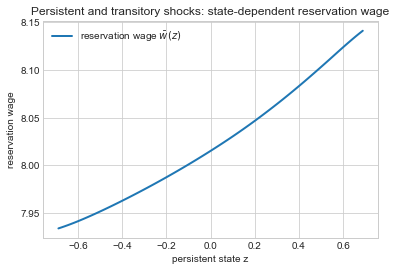

In [11]:
def plot_reservation_wage_curve(params: PersistTransParams,
                                w_bar: jnp.ndarray) -> None:
    z = np.asarray(params.z_grid)
    w_bar_np = np.asarray(w_bar)

    fig, ax = plt.subplots()
    ax.plot(z, w_bar_np, lw=2, label="reservation wage $\\bar{w}(z)$")
    ax.set_xlabel("persistent state z")
    ax.set_ylabel("reservation wage")
    ax.set_title("Persistent and transitory shocks: state-dependent reservation wage")
    ax.legend()
    plt.show()


plot_reservation_wage_curve(pt_params, res_wage_curve)


## 7. Single-Agent Simulation

To make the abstract dynamic programming problems more concrete, we now simulate the employment history of a single worker.
We use the separation model with Markov wages from Section 4, together with its optimal reservation wage.

The simulation tracks, over a long horizon:

- the sequence of wage offers and accepted wages,
- the worker's acceptance and rejection decisions, and
- the resulting employment and unemployment history.

This provides an intuitive picture of how the reservation wage policy translates into time-series behavior.



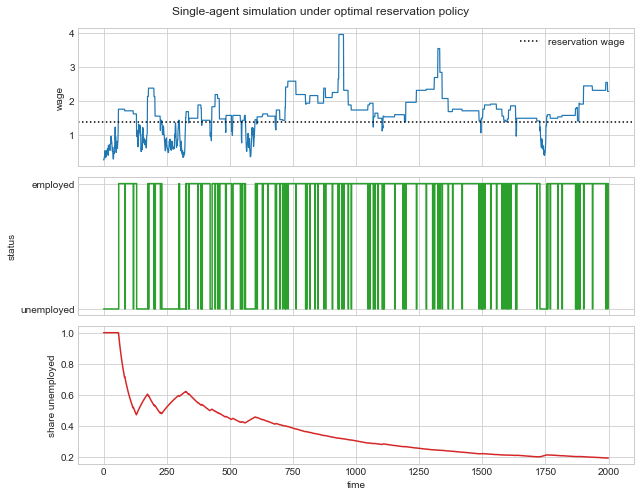

In [12]:
def update_agent_markov(key: jax.Array,
                        status: int,
                        wage_idx: int,
                        params: MarkovSeparationParams,
                        w_bar: float) -> tuple[int, int]:
    """Advance the agent one period under the optimal reservation policy.

    status: 0 = unemployed, 1 = employed.
    wage_idx: index of current wage (offer if unemployed, job if employed).
    """
    alpha, beta, gamma, c, rho, nu, n, w, P, P_cumsum = (
        params.alpha,
        params.beta,
        params.gamma,
        params.c,
        params.rho,
        params.nu,
        params.n_states,
        params.w_vals,
        params.P,
        params.P_cumsum,
    )

    key1, key2 = jax.random.split(key)

    # Draw next wage index from the Markov transition using the
    # precomputed cumulative distribution and inverse transform sampling
    u = jax.random.uniform(key1)
    new_wage_idx = int(jnp.searchsorted(P_cumsum[wage_idx, :], u))

    # With probability alpha, an employed worker loses the job
    separation_occurs = jax.random.uniform(key2) < alpha
    current_wage = float(w[wage_idx])

    # Reservation wage rule: accept if current offer is high enough
    accepts = current_wage >= w_bar

    if status == 0:
        # Unemployed today: either accept (and keep the current offer)
        # or reject (and move to a new offer drawn from P)
        next_status = int(accepts)
        next_wage_idx = wage_idx if accepts else new_wage_idx
    else:
        # Employed today: either separated (and move to unemployment with
        # a new offer) or keep the current job
        if bool(separation_occurs):
            next_status = 0
            next_wage_idx = new_wage_idx
        else:
            next_status = 1
            next_wage_idx = wage_idx

    return next_status, next_wage_idx


def simulate_employment_path_markov(params: MarkovSeparationParams,
                                    w_bar: float,
                                    T: int = 2_000,
                                    seed: int = 42) -> tuple[np.ndarray, np.ndarray]:
    """Simulate a single worker's wage and employment history."""
    key = jax.random.PRNGKey(seed)

    status = 0        # start unemployed
    wage_idx = 0      # start from the first wage state

    wages = []
    statuses = []

    for t in range(T):
        wages.append(float(params.w_vals[wage_idx]))
        statuses.append(status)

        key, subkey = jax.random.split(key)
        status, wage_idx = update_agent_markov(subkey, status, wage_idx, params, w_bar)

    return np.array(wages), np.array(statuses)


def plot_single_agent_simulation(wage_path: np.ndarray,
                                 status_path: np.ndarray,
                                 w_bar: float) -> None:
    """Plot wages, employment status, and cumulative unemployment over time."""
    T = len(wage_path)
    time = np.arange(T)

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 7), sharex=True)

    # Wage path and reservation wage
    ax1.plot(time, wage_path, lw=1.2, color="tab:blue")
    ax1.axhline(w_bar, color="k", linestyle=":", label="reservation wage")
    ax1.set_ylabel("wage")
    ax1.legend(loc="upper right")

    # Employment status path
    ax2.step(time, status_path, where="post", lw=1.5, color="tab:green")
    ax2.set_ylabel("status")
    ax2.set_yticks([0, 1])
    ax2.set_yticklabels(["unemployed", "employed"])

    # Cumulative fraction of time spent unemployed
    unemployed_indicator = (status_path == 0).astype(float)
    cumulative_unemployment = np.cumsum(unemployed_indicator) / (np.arange(T) + 1.0)

    ax3.plot(time, cumulative_unemployment, lw=1.5, color="tab:red")
    ax3.set_xlabel("time")
    ax3.set_ylabel("share unemployed")

    fig.suptitle("Single-agent simulation under optimal reservation policy")
    plt.tight_layout()
    plt.show()


# Run the simulation and display the resulting paths
wage_path, status_path = simulate_employment_path_markov(markov_params, w_bar_markov)
plot_single_agent_simulation(wage_path, status_path, w_bar_markov)


## 8. Summary and Insights

This notebook has reconstructed a family of McCall-style job search models, moving from a simple IID wage environment to richer settings with separation, Markov wages, continuous wage dynamics, and persistent plus transitory shocks.
Across all variants, the key organizing principle is the Bellman equation and the resulting reservation wage policy: workers optimally accept jobs only when current offers are sufficiently attractive relative to the continuation value of search.

From a computational perspective, we saw how value function iteration, transformations that reduce dimensionality, Markov chain approximations, and fitted value function iteration make it possible to solve increasingly complex dynamic programs.
These tools are central to modern computational economics, where heterogeneous-agent models and rich stochastic environments are the norm rather than the exception.
